## Introduction

Cricket is a sport filled with excitement, especially in the Indian Premier League (IPL) where stars from India and across the globe compete for their franchises. In IPL matches, the dynamics of a game can change rapidly, and the outcome often hinges on the performance of both batting and bowling sides during the second innings. This notebook explores the use of machine learning (ML) techniques to predict the success of a second innings chase in T20I cricket based on a set of win features that represent the state of play. These features include the number of balls remaining in the chase, the target score and the num ber of runs on the board.



## Data Setup

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
seed = 42  # Choose any seed value
np.random.seed(seed)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

# Read in data for second innings
it20_data = pd.read_csv('data_files/ball_by_ball_ipl.csv')
innings2 = it20_data.loc[it20_data['Innings'] == 2]

# Drop the last row for each run chase as the result is known
innings2 = innings2.drop(innings2[innings2['Balls Remaining'] == 0].index)
innings2.reset_index(drop=True, inplace=True)

print('No of Matches: ', innings2['Match ID'].nunique())
print('Data Frame Length: ', len(innings2.index))

innings2['Venue'] = innings2['Venue'].str.replace('M.Chinnaswamy Stadium', 'M Chinnaswamy Stadium')
innings2.head()



No of Matches:  1005
Data Frame Length:  115384


,Unnamed: 0,Match ID,Date,Venue,Bat First,Bat Second,Innings,Over,Ball,Batter,Non Striker,Bowler,Batter Runs,Extra Runs,Runs From Ball,Ball Rebowled,Extra Type,Wicket,Method,Player Out,Innings Runs,Innings Wickets,Target Score,Runs to Get,Balls Remaining,Winner,Chased Successfully,Total Batter Runs,Total Non Striker Runs,Batter Balls Faced,Non Striker Balls Faced,Player Out Runs,Player Out Balls Faced,Bowler Runs Conceded,Valid Ball
0,123,1359507,2023-04-23,Eden Gardens,Chennai Super Kings,Kolkata Knight Riders,2,1,1,N Jagadeesan,SP Narine,Akash Singh,1,0,1,0,[],0,NaN,NaN,1,0,236,235.0,119,Chennai Super Kings,0,1,0,1,0,NaN,NaN,1,1
1,124,1359507,2023-04-23,Eden Gardens,Chennai Super Kings,Kolkata Knight Riders,2,1,2,SP Narine,N Jagadeesan,Akash Singh,0,0,0,0,[],0,NaN,NaN,1,0,236,235.0,118,Chennai Super Kings,0,0,1,1,1,NaN,NaN,0,1
2,125,1359507,2023-04-23,Eden Gardens,Chennai Super Kings,Kolkata Knight Riders,2,1,3,SP Narine,N Jagadeesan,Akash Singh,0,0,0,0,[],0,NaN,NaN,1,0,236,235.0,117,Chennai Super Kings,0,0,1,2,1,NaN,NaN,0,1
3,126,1359507,2023-04-23,Eden Gardens,Chennai Super Kings,Kolkata Knight Riders,2,1,4,SP Narine,N Jagadeesan,Akash Singh,0,0,0,0,[],1,bowled,SP Narine,1,1,236,235.0,116,Chennai Super Kings,0,0,1,0,1,0.0,3.0,0,1
4,127,1359507,2023-04-23,Eden Gardens,Chennai Super Kings,Kolkata Knight Riders,2,1,5,VR Iyer,N Jagadeesan,Akash Singh,0,0,0,0,[],0,NaN,NaN,1,1,236,235.0,115,Chennai Super Kings,0,0,1,1,1,NaN,NaN,0,1


## Data Pre-processing

The features selected are defined below, I selected the numeric features which I deemed most relevant for predicting run chase success. The data is augmented so that the values of each feature at the beginning of each innings are included. This is because the ball by ball data considers the values of datapoints such as 'Runs to Get' and 'Balls Remaining' as the values after the ball in question has been bowled. That is to say, the first row of data for each innings gives the state of play after the first ball has been bowled.

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

df = innings2.copy()
l = len(df.columns)
# Perform one-hot encoding and store the newly created columns in a separate DataFrame
df_encoded = pd.get_dummies(df, columns=['Venue'])

# Get the names of the newly created columns
venues = list(df_encoded.columns)[l-1:]


# Define the features of the model
features = ['Runs From Ball','Innings Runs', 'Innings Wickets', 'Balls Remaining', 'Target Score', 'Total Batter Runs','Total Non Striker Runs','Batter Balls Faced','Non Striker Balls Faced']# + venues


# Step 2: Set the cutoff date
cutoff_date = '2019-01-01'

# Step 3: Split the data into training and test sets based on the cutoff date
train_data = df_encoded[df_encoded['Date'] < cutoff_date]
test_data = df_encoded[df_encoded['Date'] >= cutoff_date]


# Step 4: Select the relevant features for X and the target variable for y
X_train = train_data[features]
y_train = train_data['Chased Successfully']
X_test = test_data[features]
y_test = test_data['Chased Successfully']



# Step 5: Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)





Here, the data is split into a training and a test set by setting a cutoff data as 1/1/2019, any match before before that date belongs to the training data and any match after that date belongs to the test data. The X data is scaled using the StandardScaler() function, this is important for machine learning classifiers like logistic regression.

## Training ML Classifiers

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

random_state = 42

# Define a list of classifiers
classifiers = [
    ("Logistic Regression", LogisticRegression(random_state=random_state)),
    ("Random Forest", RandomForestClassifier(random_state=random_state)),
    
    ("Gradient Boosting", GradientBoostingClassifier(random_state=random_state)),
    ("XGBoost", XGBClassifier(random_state=random_state))
]

# Train and evaluate each classifier
for name, model in classifiers:
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    print(f"{name} Accuracy: {score:.3f}")





    

Logistic Regression Accuracy: 0.778
Random Forest Accuracy: 0.746
Gradient Boosting Accuracy: 0.770
XGBoost Accuracy: 0.746


The accuracy is similar for Gradient Boosting and Logistic Regression but Logistic Regression achieves marginally the higher accuracy on the validation dataset. Encoding the venues as binary features reduces the accuracy.

Accuracy: 0.7779060092863469


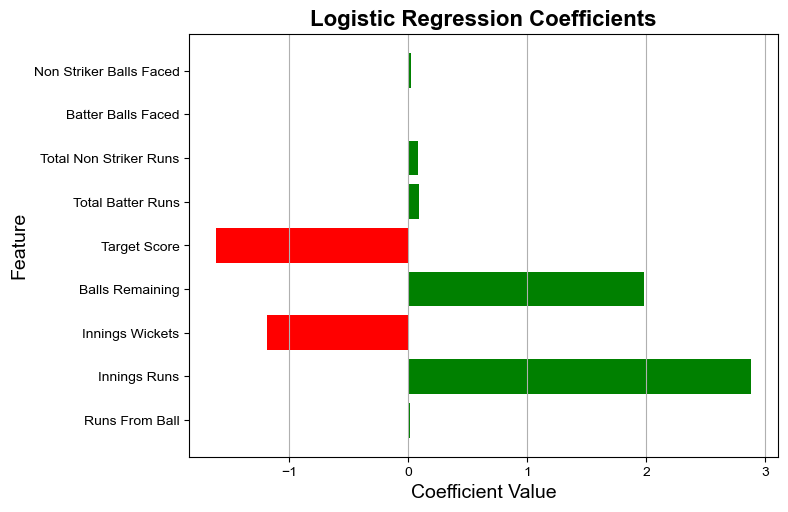

In [27]:
# Train the logistic regression model
model = LogisticRegression(C=1)
model.fit(X_train, y_train)

# Evaluate the model on the testing set
LR_score = model.score(X_test, y_test)
# Print the accuracy
print("Accuracy:", LR_score)

#Get the coefficients
coefs = model.coef_[0]

# Create horizontal bar plot with colors
colors = ['green' if c > 0 else 'red' for c in coefs]
fig, ax = plt.subplots()
ax.barh(features, coefs, color=colors)

# Adjust layout and font
fig.set_size_inches(8, 5)
plt.tight_layout(pad=2)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

# Add title and axis labels
ax.set_title('Logistic Regression Coefficients', fontsize=16, fontweight='bold')
ax.set_xlabel('Coefficient Value', fontsize=14)
ax.set_ylabel('Feature', fontsize=14)

# Add horizontal grid lines
ax.xaxis.grid(True)



# Show plot
plt.show()

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

df = innings2
phases = ['Powerplay', 'Middle Overs', 'Final Overs']
for i, phase in enumerate(phases):
    print('Phase of Play: ', phase)
    if i == 0:
        data = df[df['Balls Remaining'] > 84]
    elif i == 1:
        data = df[(df['Balls Remaining'] > 30) & (df['Balls Remaining'] <= 84)]
    else:
        data = df[df['Balls Remaining'] <= 30]

    # Step 2: Set the cutoff date
    cutoff_date = '2018-01-01'

    # Step 3: Split the data into training and test sets based on the cutoff date
    train_data = data[data['Date'] < cutoff_date]
    test_data = data[data['Date'] >= cutoff_date]


    # Step 4: Select the relevant features for X and the target variable for y
    X_train = train_data[features]
    y_train = train_data['Chased Successfully']
    X_test = test_data[features]
    y_test = test_data['Chased Successfully']



    # Step 5: Scale the features using StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train the logistic regression model
    model = LogisticRegression(C=1)
    model.fit(X_train, y_train)

    # Evaluate the model on the testing set
    LR_score = model.score(X_test, y_test)

    # Print accuracy of the model
    print("Accuracy of {} Classifier:".format(phase), LR_score)
    

Phase of Play:  Powerplay
Accuracy of Powerplay Classifier: 0.6970978562053376
Phase of Play:  Middle Overs
Accuracy of Middle Overs Classifier: 0.7713280986560046
Phase of Play:  Final Overs
Accuracy of Final Overs Classifier: 0.8531114327062229


| Phase of Play | Test Accuracy |
|----------|----------|
| Powerplay (Overs 1-6) | 69.71 |
| Middle Overs (Overs 7-15) | 77.13 |
| Final Overs  (Overs 16-20) | 85.31 |

As suspected, the classifier which is trained and evaluated on solely the data from overs 1-6 has significantly poorer accuracy compared to the classifiers trained on data from the other two phases of the second innings. In fact, by training and evaluating on purely the data from the middle and final overs respectively, the accuracy achieved increases considerably. Intuitively, this was expected as the poor prediction near the start of the innings was thought to be dragging down the accuracy for the overall classifier. 

The classifiers perform worse on IPL data than the T20I data possible due to the teams being more balanced in terms of ability.